# Backdoor v1: Using `Re78`

Using linear regression to model using a backdoor estimator on `Re78` before and after job training.

In [1]:
import sys

In [2]:
# append parent directory to use utils
sys.path.append("../")

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils.backdoor_utils import backdoor_lr, backdoor_param_a, mean_diff_estimator
from utils.bootstrap import bootstrap, bootstrap_experiment

In [4]:
lalonde_exp = pd.read_csv("../data/lalonde_exp.csv")
lalonde_obs = pd.read_csv("../data/lalonde_psid.csv")

In [5]:
lalonde_exp.shape, lalonde_obs.shape

((445, 13), (2675, 13))

## Experimental Estimate

$Re_{78}^{a=1} - Re_{78}^{a=0}$

Here $a$ is just the experimental cohort. It is not the counterfactual.

In [6]:
mean_diff = (
    lalonde_exp.loc[lalonde_exp["treat"] == 1, "re78"].mean()
    - lalonde_exp.loc[lalonde_exp["treat"] == 0, "re78"].mean()
)
mean_diff

1794.3430848752596

Our point estimate on the experimental data is then roughly US$1794.3

In [7]:
n_values = range(10, 100, 10)
ci_results = []

for n in n_values:
    ci = bootstrap(
        lalonde_exp,
        mean_diff_estimator,
        n,
        95,
        treatment_col="treat",
        outcome_col="re78",
    )
    ci_results.append({"n": n, "mean": ci[0], "lower_ci": ci[1], "upper_ci": ci[2]})

In [8]:
ci_df = pd.DataFrame(ci_results)

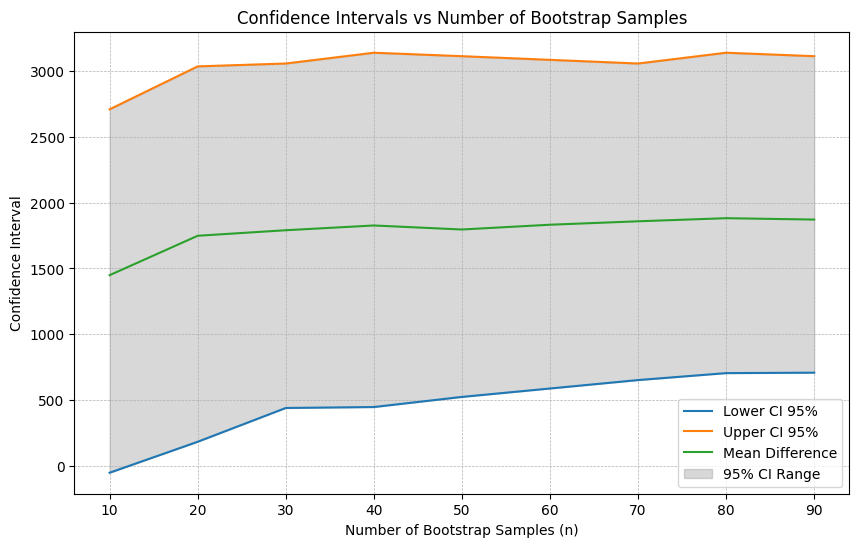

In [9]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="n", y="lower_ci", data=ci_df, label="Lower CI 95%")
sns.lineplot(x="n", y="upper_ci", data=ci_df, label="Upper CI 95%")
sns.lineplot(x="n", y="mean", data=ci_df, label="Mean Difference")
plt.fill_between(
    ci_df["n"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(n_values)
plt.xlabel("Number of Bootstrap Samples (n)")
plt.ylabel("Confidence Interval")
plt.title("Confidence Intervals vs Number of Bootstrap Samples")
plt.legend()
plt.show()

We can see that the CIs stabilize at around 800 samples, so we'll be using 800 samples to calculate our CI.

In [10]:
ci = bootstrap(
    lalonde_exp,
    mean_diff_estimator,
    50,
    95,
    treatment_col="treat",
    outcome_col="re78",
)

In [11]:
print(
    f"Causal estimate of `Re78` in experimental data as a difference of means is "
    f"US${ci[0]:.2f} ± [{ci[1]:.2f}, {ci[2]:.2f}]"
)

Causal estimate of `Re78` in experimental data as a difference of means is US$1796.24 ± [522.92, 3114.44]


## Backdoor Estimator

Assume $Y$ represents our outcome variable, i.e., `re78`. Our set of confounders is $Z=$ {`education, re74, re75, black, hispanic, married`}. $A$ is our intervention variable which represents `treat` or job training. Our derivation for the counterfactual function looks below:

\begin{align}
E[Y^a - Y^{a'}]
&= E[Y^a] - E[Y^{a'}] \tag{1}\\
&= p(Y^a) - p(Y^{a'}) \tag{2}\\
&= \sum_Z p(Y^a \mid z) p(z) - \sum_Z p(Y^{a'} \mid z) p(z) \tag{3}\\
&= \sum_Z p(Y^a \mid a, z) p(z) - \sum_Z p(Y^{a'} \mid a', z) p(z) \tag{4}\\
&= \sum_Z p(Y \mid a, z) p(z) - \sum_Z p(Y \mid a', z) p(z) \tag{5} \\
&= \sum_Z p(z) [p(Y \mid a, z) - p(Y \mid a', z)] \tag{6}
\end{align}

1. Linearity of expectation.
2. Equivalence of expectation and probabilities.
3. Marginalizing over $Z$.
4. Using conditional exchangeability: $p(Y^a \mid a, z) = p(Y \mid a, z)$.
5. Using consistency: $p(Y^a \mid a, z) = p(Y \mid a, z)$.

### Using difference of Means in LR

#### Without Correlated factors

In [12]:
backdoor_result = backdoor_lr(
    lalonde_exp,
    "treat",
    "re78",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(
    f"The difference between the treatment and no-treatment groups is {backdoor_result:.2f}."
)

The difference between the treatment and no-treatment groups is 1632.64.


In [13]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_lr,
    num_exp=10,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.97it/s]


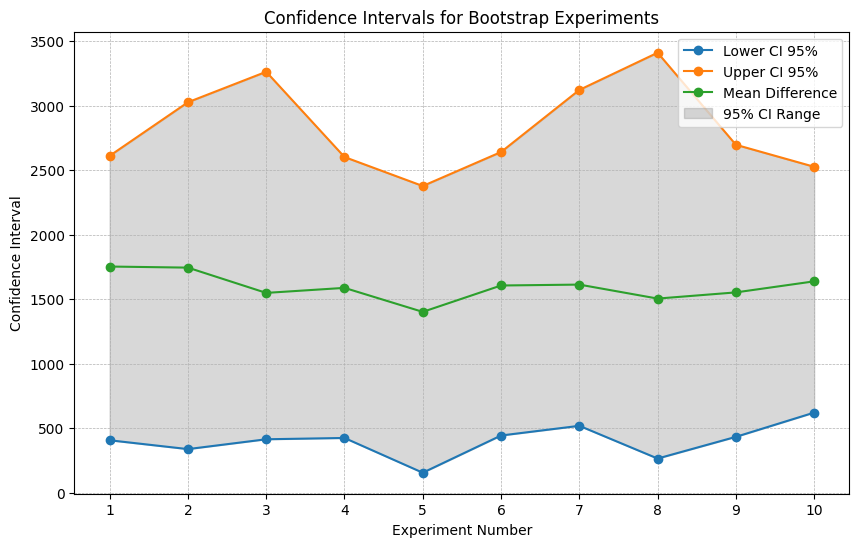

In [14]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(10, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="Mean Difference", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Confidence Intervals for Bootstrap Experiments")
plt.legend()
plt.show()

In [15]:
ci_df

,mean,lower_ci,upper_ci,experiment
0,1753.097820,407.342001,2610.452230,1
1,1744.687681,338.924093,3025.622043,2
2,1548.884928,415.147393,3261.721947,3
3,1587.826355,425.242415,2601.379995,4
4,1401.884373,155.998951,2376.855673,5
5,1606.232433,444.202836,2640.129338,6
6,1613.207309,519.344584,3121.016308,7
7,1504.938235,265.805304,3409.296910,8
8,1552.779376,433.866662,2696.163933,9
9,1638.469673,621.736993,2525.744551,10


#### With Correlated factors

In [16]:
backdoor_result = backdoor_lr(
    lalonde_exp,
    "treat",
    "re78",
    ["age", "education", "black", "hispanic", "married", "re74", "re75", "nodegree"],
)
print(
    f"The difference between the treatment and no-treatment groups is {backdoor_result:.2f}."
)

The difference between the treatment and no-treatment groups is 1621.58.


In [17]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_lr,
    num_exp=10,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
        "nodegree",
    ],
)

Running experiments: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]


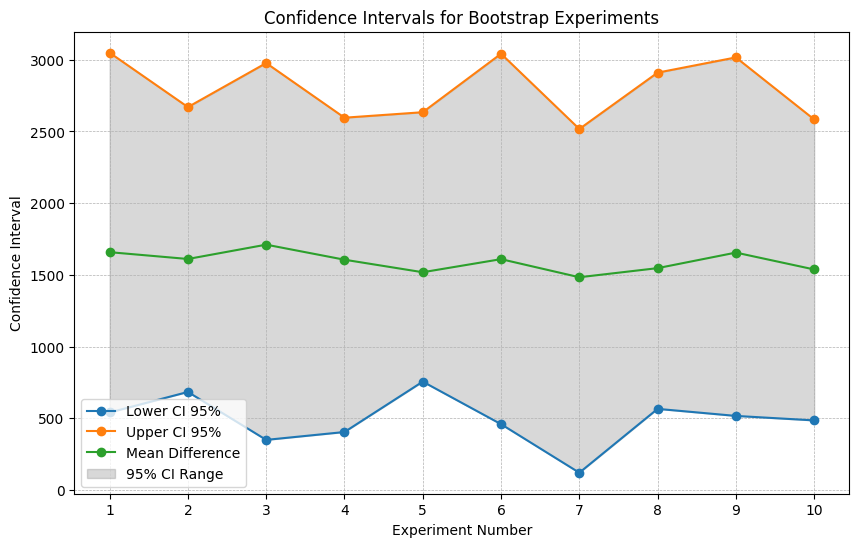

In [18]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(10, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="Mean Difference", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Confidence Intervals for Bootstrap Experiments")
plt.legend()
plt.show()

In [19]:
ci_df

,mean,lower_ci,upper_ci,experiment
0,1657.827792,539.952829,3048.711557,1
1,1610.354579,683.172668,2669.591077,2
2,1710.287654,348.868422,2976.708342,3
3,1605.316155,403.763000,2595.586731,4
4,1517.945799,755.045747,2633.801730,5
5,1609.207825,458.446487,3041.535733,6
6,1483.022465,119.890440,2516.813837,7
7,1546.522429,565.142081,2909.839599,8
8,1654.975674,516.040231,3016.007861,9
9,1537.327036,484.725706,2583.359834,10


## Using a's parameters

Assume $\beta$ is our causal risk difference.

\begin{align}
\beta
&= \sum_Z p(z) [E(Y \mid a, z) - E(Y \mid a', z)] \tag{1} \\
&= \frac{1}{N} \sum_{i}^{N} [E(Y \mid a, Z_{i}) - E(Y \mid a', Z_{i})] \tag{2} \\
&= \frac{1}{N} \sum_{i}^{N} [(\omega_0 + \omega_{A} \cdot 1 + \omega_{Z}Z) - (\omega_0 + \omega_{A} \cdot 0 + \omega_{Z}Z)] \tag{3} \\
&= \frac{1}{N} \sum_{i}^{N} \omega_{A} \tag{4} \\
&= \omega_{A} \tag{5}
\end{align}

1. Relating expectations to probabilities.
2. Using the uniform distribution of $p(Z_i)$.
3. Linear regression modeling where $A = \{0, 1\}$.
4. Simplifying to isolate $\omega_A$.
5. Resulting in $\omega_A$ representing the causal risk difference.

Hence we're only interested in the parameters of $\omega_A$ for our causal risk difference.

In [20]:
backdoor_result = backdoor_param_a(
    lalonde_exp,
    "treat",
    "re78",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(
    f"The difference between the treatment and no-treatment groups is {backdoor_result:.2f}."
)

The difference between the treatment and no-treatment groups is 1682.59.


In [21]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_param_a,
    num_exp=10,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.98it/s]


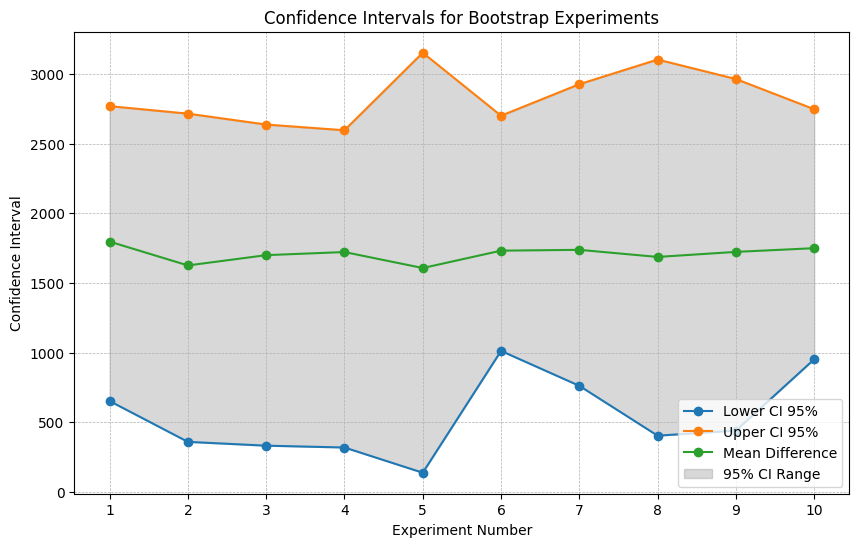

In [22]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(10, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="Mean Difference", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Confidence Intervals for Bootstrap Experiments")
plt.legend()
plt.show()

In [23]:
ci_df

,mean,lower_ci,upper_ci,experiment
0,1796.059371,651.784690,2768.352040,1
1,1625.030327,358.941973,2714.348600,2
2,1698.962773,331.624078,2636.233175,3
3,1721.255350,318.459984,2595.219774,4
4,1606.474767,137.511205,3151.704196,5
5,1731.199293,1011.692777,2699.623183,6
6,1737.057090,761.169323,2925.813266,7
7,1686.099377,403.359902,3102.562802,8
8,1722.332893,439.647359,2962.973532,9
9,1748.968722,951.558715,2746.104457,10


## Using Observational data

### Difference of means

In [24]:
mean_diff = (
    lalonde_obs.loc[lalonde_obs["treat"] == 1, "re78"].mean()
    - lalonde_obs.loc[lalonde_obs["treat"] == 0, "re78"].mean()
)
mean_diff

-15204.775555988717

### Using difference of means in LR

In [25]:
backdoor_result = backdoor_lr(
    lalonde_obs,
    "treat",
    "re78",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(
    f"The difference between the treatment and no-treatment groups is {backdoor_result:.2f}."
)

The difference between the treatment and no-treatment groups is -8910.05.


In [26]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_lr,
    num_exp=10,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.15it/s]


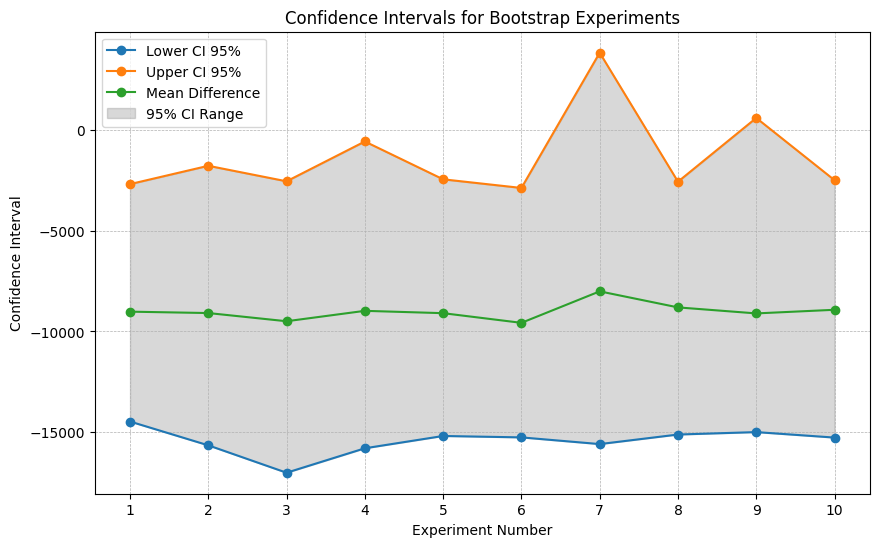

In [27]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(10, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="Mean Difference", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Confidence Intervals for Bootstrap Experiments")
plt.legend()
plt.show()

In [28]:
ci_df

,mean,lower_ci,upper_ci,experiment
0,-9014.270105,-14474.969560,-2675.290601,1
1,-9083.313924,-15658.182023,-1764.597080,2
2,-9490.584276,-17019.417682,-2535.791800,3
3,-8973.216976,-15804.635758,-555.978896,4
4,-9089.646260,-15192.928858,-2436.730586,5
5,-9570.110431,-15263.334879,-2865.669967,6
6,-8005.005977,-15596.261429,3855.445093,7
7,-8802.271953,-15120.949307,-2554.933080,8
8,-9101.491250,-15000.325630,614.219328,9
9,-8920.980476,-15273.043963,-2480.918967,10


### Using a's parameters

In [29]:
backdoor_result = backdoor_param_a(
    lalonde_obs,
    "treat",
    "re78",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(
    f"The difference between the treatment and no-treatment groups is {backdoor_result:.2f}."
)

The difference between the treatment and no-treatment groups is 859.77.


In [30]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_param_a,
    num_exp=10,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.87it/s]


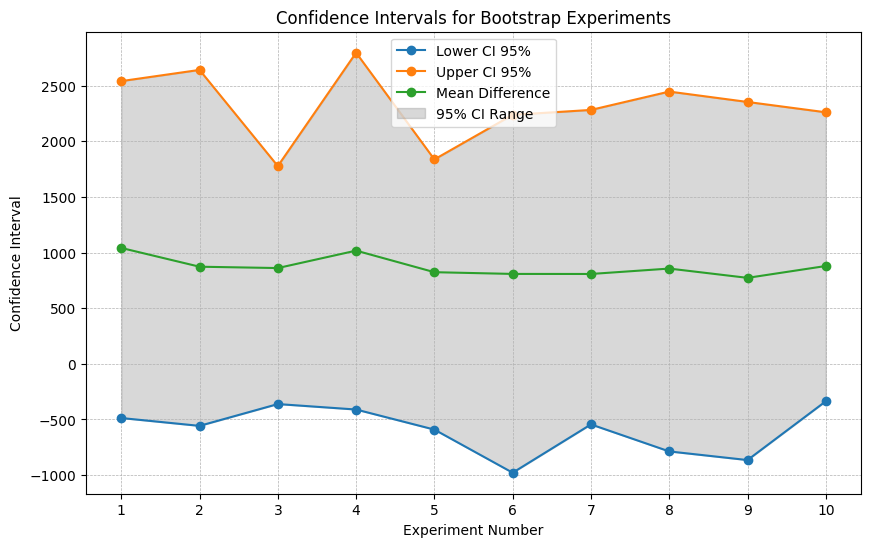

In [31]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(10, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="Mean Difference", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Confidence Intervals for Bootstrap Experiments")
plt.legend()
plt.show()

In [32]:
ci_df

,mean,lower_ci,upper_ci,experiment
0,1041.784520,-487.401964,2541.684196,1
1,873.037940,-557.906540,2642.473340,2
2,860.972645,-361.890736,1777.807628,3
3,1017.661655,-411.000973,2797.015559,4
4,823.747821,-591.496082,1837.744339,5
5,808.196694,-979.192325,2238.475847,6
6,807.732473,-544.794431,2282.732841,7
7,856.350070,-787.684469,2447.687749,8
8,772.790173,-865.347289,2354.318915,9
9,879.394066,-336.621381,2261.466387,10
